## **Speed Challenge v3**


**Only run this cell if you want to use SIFT**


---


This section does not need to be run.




In [0]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

In [0]:
import os
import cv2
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io, transform

import torch
import torch.nn as nn
import torch.nn.functional as F 
import torchvision.transforms.functional as TF
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms, models, utils
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
print('torch version: {}'.format(torch.__version__))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: {}'.format(device))

torch version: 1.3.1
device: cuda


**Mount Google Drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Filenames**

In [0]:
#train_video = '/content/drive/My Drive/speed/train.mp4'
speed_file = '/content/drive/My Drive/speed/train.txt'
#frame_dir = os.path.join(os.getcwd(),'frame_dir')
#!mkdir frame_dir

#test_video = '/content/drive/My Drive/speed/test.mp4'
#frame_dir = '/content/drive/My Drive/speed/frame_dir'

**Crop images using a trapezoidal mask**


---

This ensures the focus is only on the section of road directly infront of the car


In [0]:
frame_mask_dir = '/content/drive/My Drive/speed/frame_mask_dir'

start = time.time()
def pre_compute(frame_dir,out_dir = frame_mask_dir):
  list_of_img = os.listdir(frame_dir)
  for idx,img_frame in enumerate(list_of_img):
    img_file = os.path.join(frame_dir,'{}'.format(img_frame))
    img = cv2.imread(img_file)[..., ::-1]
    img = crop_mask_trapezoid(img)
    img = crop_box(img)
    outfile = os.path.join(frame_mask_dir,'{}'.format(img_frame))
    cv2.imwrite(outfile,img)
    if idx % 100 == 0 and idx != 0:
      print(timeSince(start, idx/20400))

## **Helpers**


---
Code: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html



In [0]:
def asMinutes(sec):
    m = math.floor(sec / 60)
    sec = sec % 60
    return '{}m {}s'.format(int(m), int(sec))

def timeSince(since, percent):
    now = time.time()
    sec = now - since
    estimated_sec = sec / (percent)
    remaining_sec = estimated_sec - sec
    return '{} (- {})'.format(asMinutes(sec), asMinutes(remaining_sec))

## **Data**


---

Video with 20,400 frames at 20 frames/sec. Data from https://github.com/commaai/speedchallenge.

In [0]:
def split_video(video_dir, print_every=1000):
    start = time.time()
    num_frames = 20400
    
    cap = cv2.VideoCapture(video_dir)
    current_frame = 0
    print('Creating Images...')
    while(True):
        ret, frame = cap.read()
        if ret:
            img = os.path.join(frame_dir,str(current_frame)+'.jpg')
            cv2.imwrite(img,frame)
            current_frame += 1
            if current_frame % print_every == 0:
                print(timeSince(start,current_frame/num_frames))
        else:
            print('Wrote {} Frames...'.format(current_frame))
            break
    cap.release()
    cv2.destroyAllWindows()

def read_text(speed_dir = speed_file):
    with open(speed_dir, 'r') as f:
        data = f.read()
    return [float(x) for x in data.split()]

speed_arr = read_text()
frame = np.random.choice(20400,1)[0]

def crop_mask_trapezoid(frame):
  w = frame.shape[0]
  h = frame.shape[1]

  mask = np.zeros([w,h,frame.shape[2]],dtype=np.uint8)
  pts = np.array([[80,350],[560,350],[420,220],[220,220]],dtype=np.int32)
  
  ignore_mask_color = (255,)*frame.shape[2]

  cv2.fillPoly(mask, [pts], ignore_mask_color)
  
  masked_image = cv2.bitwise_and(frame, mask)
  
  return masked_image

def show_frame(frame,fr_dir): 
  fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,10))
  img_frame = os.path.join(fr_dir,'{}.jpg'.format(frame))
  
  img = cv2.imread(img_frame)
  img = img[..., ::-1]
  img2 = img.copy()
  
  print('Image shape:',img.shape)  
  print('Frame: {} Speed: {} Image: {}'.format(frame, speed_arr[frame], img_frame))
  
  ax1.imshow(img)
  ax2.imshow(crop_mask_trapezoid(img2))

#show_frame(frame)

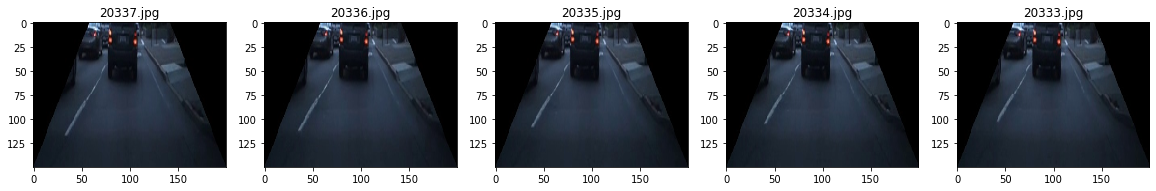

In [0]:
def crop_box(frame):
  return frame[220:350,80:560,:]

def show_seq(idx):
  seq_list = [os.path.join(frame_mask_dir,'{}.jpg'.format(abs(idx-(1*b)))) for b in list(np.arange(5))]
  img_list = []
  
  for img_frame in seq_list:
    img = cv2.imread(img_frame)[..., ::1]
    img = cv2.resize(img,(200,150))
    img_list.append(img)
  
  fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(20,20))
  ax1.set_title(seq_list[0][-9:])
  ax1.imshow(img_list[0])
  ax2.set_title(seq_list[1][-9:])
  ax2.imshow(img_list[1])
  ax3.set_title(seq_list[2][-9:])
  ax3.imshow(img_list[2])
  ax4.set_title(seq_list[3][-9:])
  ax4.imshow(img_list[3])
  ax5.set_title(seq_list[4][-9:])
  ax5.imshow(img_list[4])
  
show_seq(20337)

## **Dataset Sequence Raw Frames**


---

This is a dataset that loads 5 images in sequence

In [0]:
data_transforms = {'train':
                   transforms.Compose([
                       transforms.Resize((100,300)),
                       transforms.ToTensor(),
                       transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
                   ]),
                  'val':
                   transforms.Compose([
                   transforms.Resize((100,300)),
                   transforms.ToTensor(),
                   transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
                   ])
                  }

class SpeedDataset(Dataset):
    def __init__(self, txt_array, f_dir, trans=None):
        self.speed_arr = txt_array
        self.frames = f_dir
        self.transform = trans
    
    def __len__(self):
        return len(self.speed_arr)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        speed = torch.tensor(float(speed_arr[idx]))
            
        seq_list = [os.path.join(self.frames,'{}.jpg'.format(abs(idx-(1*b)))) for b in list(np.arange(4))]

        img1 = self.transform(Image.open(seq_list[0]))
        img2 = self.transform(Image.open(seq_list[1]))
        img3 = self.transform(Image.open(seq_list[2]))
        img4 = self.transform(Image.open(seq_list[3]))

        sample = {'seq': torch.stack((img1,img2,img3, img4),axis=0), 'label': speed}
        return sample      

In [0]:
speed_datasets = {x: SpeedDataset(txt_array=speed_file,
                                  f_dir=frame_mask_dir,
                                  trans=data_transforms[x]) 
                  for x in ['train','val']}

num_frames = len(speed_arr)

index = list(range(num_frames))
train_val_split = 18400

np.random.shuffle(index)
train_idx, val_idx = index[:train_val_split], index[train_val_split:]

sample = {'train': SubsetRandomSampler(train_idx), 'val': SubsetRandomSampler(val_idx)}
dataloaders = {x: DataLoader(speed_datasets[x], 
                             sampler = sample[x], 
                             batch_size=2, 
                             num_workers=2) 
               for x in ['train', 'val']}
dataset_sizes = {'train': len(train_idx), 'val': len(val_idx)}

print('Train: {} Val: {}'.format(dataset_sizes['train'],dataset_sizes['val']))

Train: 18400 Val: 2000


torch.Size([2, 4, 3, 100, 300])
Speed:  2.0762860774993896


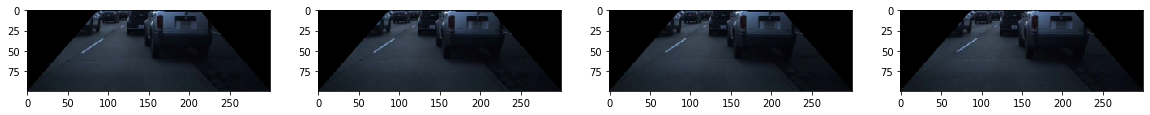

In [0]:
inputs = next(iter(dataloaders['train']))

seq_test = inputs['seq']
label_test = inputs['label'][0]

print(seq_test.size())

def denorm(img):
    mean = np.array([0.5,0.5,0.5])
    std = np.array([0.5,0.5,0.5])
    img = std * img + mean
    return img

def img_show(img):
    img = img.numpy().transpose((1,2,0))
    img = img[:,:,::-1]
    img = np.clip(denorm(img),0,1)
    return(img)

print("Speed: ",label_test.item())
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(20,20))
ax1.imshow(img_show(seq_test[0][0]))
ax2.imshow(img_show(seq_test[0][1]))
ax3.imshow(img_show(seq_test[0][2]))
ax4.imshow(img_show(seq_test[0][3]))
plt.show()

## **Different Inputs That Were Tested**

**Laplacian**


---

Laplacian is a promising approach

Code: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_gradients/py_gradients.html

Image shape: (130, 480, 3)
Frame: 11430 Speed: 2.006547 Image: /content/drive/My Drive/speed/frame_mask_dir/11430.jpg


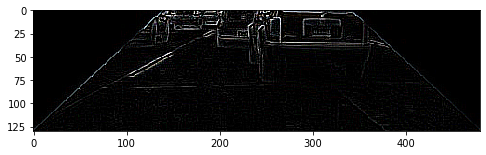

In [0]:
frame = np.random.choice(20400,1)[0]

def lapalacian(frame):
  fig, (ax1) = plt.subplots(1, 1,figsize=(8,8))
  img_frame = os.path.join(frame_mask_dir,'{}.jpg'.format(frame))
  
  img = cv2.imread(img_frame)
  img2 = img.copy()
  
  laplacian = cv2.Laplacian(img2,cv2.CV_8U,ksize=3)
  
  print('Image shape:',img.shape)  
  print('Frame: {} Speed: {} Image: {}'.format(frame, speed_arr[frame], img_frame))
  
  ax1.imshow(laplacian)
  
  return

lapalacian(frame)

## **SIFT Keypoints**


---

Detecy keypoints using SIFT and then draw them on a matrix with a Gaussian Kernel. Run the results through a Recurrent Network.
Code used: https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html

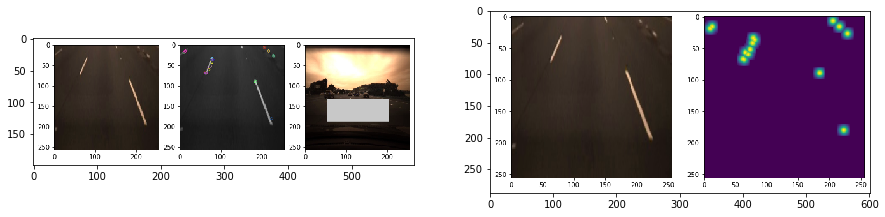

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
kp1 = Image.open('/content/drive/My Drive/speed/download.png')
kp2 = Image.open('/content/drive/My Drive/speed/download (1).png')
 
ax1.imshow(kp2)
ax2.imshow(kp1)

**Optical Flow**


---

Lucas-Kanade optical flow was not used.
Code: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_lucas_kanade/py_lucas_kanade.html

Image shape: (130, 480, 3)
Frame: 966 Speed: 19.552265 Image: /content/drive/My Drive/speed/frame_mask_dir/966.jpg


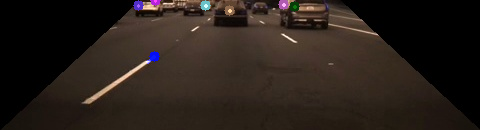

In [0]:
from google.colab.patches import cv2_imshow

frame1 = np.random.choice(20400,1)[0]
frame2 = frame1-1

feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

def optical_flow(frame1,frame2):
  fr1 = os.path.join(frame_mask_dir,'{}.jpg'.format(frame1))
  fr2 = os.path.join(frame_mask_dir,'{}.jpg'.format(frame2))
  
  img1 = cv2.imread(fr1)
  img2 = cv2.imread(fr2)
  
  old_gray = cv2.cvtColor((img1), cv2.COLOR_BGR2GRAY)
  new_gray = cv2.cvtColor((img2), cv2.COLOR_BGR2GRAY)
  
  p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
  
  mask = np.zeros_like(img1)
  color = np.random.randint(0,255,(100,3))

  # calculate optical flow
  p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, new_gray, p0, None, **lk_params)

  # Select good points
  good_new = p1[st==1]
  good_old = p0[st==1]

  # draw the tracks
  for i,(new,old) in enumerate(zip(good_new,good_old)):
      a,b = new.ravel()
      c,d = old.ravel()
      mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
      fram = cv2.circle(img1,(a,b),5,color[i].tolist(),-1)
  img = cv2.add(fram,mask)

  print('Image shape:',img.shape)  
  print('Frame: {} Speed: {} Image: {}'.format(frame1, speed_arr[frame1], fr1))
  cv2_imshow(img)
    
  return

optical_flow(frame1,frame2)

**Dense Optical Flow**


---

Dense optical flow is a promising approach. Code: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_lucas_kanade/py_lucas_kanade.html

Image shape: (130, 480, 3)
Frame: 5000 Speed: 22.163167 Image: /content/drive/My Drive/speed/frame_mask_dir/5000.jpg


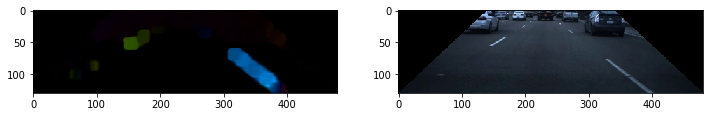

In [0]:
frame1 = 5000
frame2 = frame1-1

fr1 = os.path.join(frame_mask_dir,'{}.jpg'.format(frame1))
fr2 = os.path.join(frame_mask_dir,'{}.jpg'.format(frame2))

img1 = cv2.imread(fr1)
img2 = cv2.imread(fr2)

new_gray = cv2.cvtColor((img1), cv2.COLOR_BGR2GRAY)
old_gray = cv2.cvtColor((img2), cv2.COLOR_BGR2GRAY)

hsv = np.zeros_like(img2)
hsv[...,1] = 255

flow = cv2.calcOpticalFlowFarneback(old_gray,new_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
hsv[...,0] = ang*180/np.pi/2
hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

print('Image shape:',rgb.shape)  
print('Frame: {} Speed: {} Image: {}'.format(frame1, speed_arr[frame1], fr1))

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(12,12))
ax1.imshow(rgb)
ax2.imshow(img1)

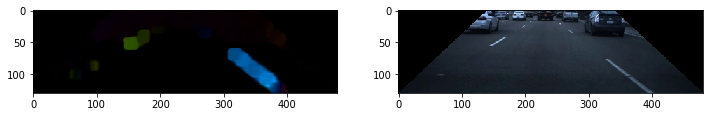

In [0]:
frame1 = os.path.join(frame_mask_dir,'{}.jpg'.format(frame1))
frame2 = os.path.join(frame_mask_dir,'{}.jpg'.format(frame2))

def compute_Gunner_Farneback(old_frame,new_frame):
  old = cv2.imread(old_frame)
  new = cv2.imread(new_frame)
  
  new_gray = cv2.cvtColor((new), cv2.COLOR_BGR2GRAY)
  old_gray = cv2.cvtColor((old), cv2.COLOR_BGR2GRAY)
  
  hsv = np.zeros_like(old)
  hsv[...,1] = 255
  
  flow = cv2.calcOpticalFlowFarneback(old_gray,new_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
  mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
  hsv[...,0] = ang*180/np.pi/2
  hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
  rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
  
  return rgb

img = compute_Gunner_Farneback(frame2,frame1)
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(12,12))
ax1.imshow(rgb)
ax2.imshow(img1)

## **Dataset Optical Flow**


---

This is a dataset that loads optical flow images.

In [0]:
import random 

class Rand_Translate_and_Blur(object):
    def __init__(self, translate_limit):
        assert isinstance(translate_limit, float)
        self.lim = translate_limit

    def __call__(self, sample):
      height = sample.shape[0] 
      width = sample.shape[1] 
      
      shift_w = random.uniform(-self.lim,self.lim)
      shift_h = random.uniform(-self.lim,self.lim)
      b = random.uniform(0,self.lim)
      b = b+3
      
      T = np.float32([[1, 0, width*shift_w], [0, 1, height*shift_h]]) 
      img = cv2.warpAffine(sample, T, (width, height)) 
      
      sigma = 0.3*((b-1)*0.5 - 1) + 0.8
      img = cv2.GaussianBlur(img,(3,3),sigma)
      return img

In [0]:
data_transforms = {'train':
                   transforms.Compose([
                       #transforms.Resize((100,300)),
                       Rand_Translate_and_Blur(.025),
                       transforms.ToTensor(),
                       transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
                   ]),
                  'val':
                   transforms.Compose([
                   #transforms.Resize((100,300)),
                   transforms.ToTensor(),
                   transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
                   ])
                  }

class SpeedDataset(Dataset):
    def __init__(self, txt_array, f_dir, trans=None):
        self.speed_arr = txt_array
        self.frames = f_dir
        self.transform = trans
    
    def __len__(self):
        return len(self.speed_arr)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        speed = torch.tensor(float(speed_arr[idx]))
            
        seq_list = [os.path.join(self.frames,'{}.jpg'.format(abs(idx-(1*b)))) for b in list(np.arange(2))]
        
        dense = compute_Gunner_Farneback(seq_list[1],seq_list[0])

        dense = self.transform(dense)

        sample = {'seq': dense, 'label': speed}
        return sample      

In [0]:
speed_datasets = {x: SpeedDataset(txt_array=speed_file,
                                  f_dir=frame_mask_dir,
                                  trans=data_transforms[x]) 
                  for x in ['train','val']}

num_frames = len(speed_arr)

index = list(range(num_frames))
train_val_split = 18400

train_idx, val_idx = index[:train_val_split], index[train_val_split:]
np.random.shuffle(train_idx)

sample = {'train': SubsetRandomSampler(train_idx), 'val': SubsetRandomSampler(val_idx)}
dataloaders = {x: DataLoader(speed_datasets[x], 
                             sampler = sample[x], 
                             batch_size=4, 
                             num_workers=4) 
               for x in ['train', 'val']}
dataset_sizes = {'train': len(train_idx), 'val': len(val_idx)}

print('Train: {} Val: {}'.format(dataset_sizes['train'],dataset_sizes['val']))

Train: 18400 Val: 2000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.9765) tensor(-1.)
torch.Size([4, 3, 130, 480])
Speed:  21.72809600830078


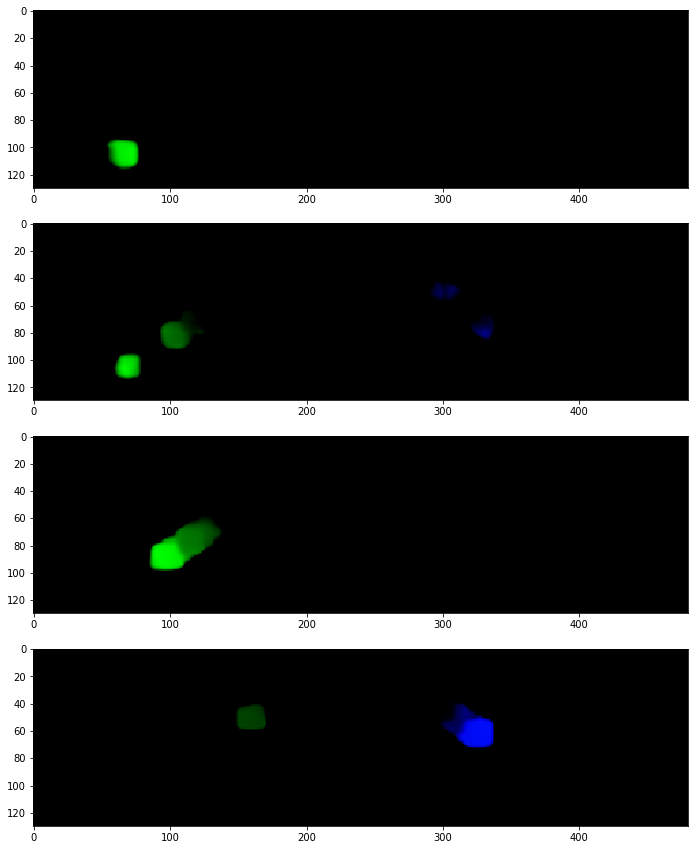

In [0]:
inputs = next(iter(dataloaders['train']))

seq_test = inputs['seq']

print(seq_test[0].max(),seq_test[0].min())

label_test = inputs['label'][0]

print(seq_test.size())
print("Speed: ",label_test.item())
img1 = seq_test[0].numpy().transpose((1,2,0))
img2 = seq_test[1].numpy().transpose((1,2,0))
img3 = seq_test[2].numpy().transpose((1,2,0))
img4 = seq_test[3].numpy().transpose((1,2,0))
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1,figsize=(15,15))
ax1.imshow((img1))
ax2.imshow((img2))
ax3.imshow((img3))
ax4.imshow((img4))

**Ideas**


---

1. Context Stream and Fovea Stream
2. GRU Network with CNN embedding layer
3. Optical Flow CNN
4. GRU Network with keypoints
5. Hilberts curve for keypoint mapping

## **CNN RESNET**

---

I was running one epoch at a time manually for testing purposes. The CNN is trained on the dense optical flow images that are shown above. The CNN is a pretrained Resnet18. https://arxiv.org/pdf/1512.03385.pdf

In [0]:
net = models.resnet18(pretrained=True)

child_counter = 0
for child in net.children():
  child_counter = 0
for child in net.children():
  if child_counter <= 4:
    print("Child ",child_counter," was frozen")
    for param in child.parameters():
      param.requires_grad = False
  else:
    print("Child ",child_counter," was not frozen")
  child_counter += 1

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 15.0MB/s]


Child  0  was frozen
Child  1  was frozen
Child  2  was frozen
Child  3  was frozen
Child  4  was frozen
Child  5  was not frozen
Child  6  was not frozen
Child  7  was not frozen
Child  8  was not frozen
Child  9  was not frozen


In [0]:
num_ftrs_linear = net.fc.in_features
net.fc = nn.Linear(num_ftrs_linear, 1)

net.to(device)
print(device)

from torch.optim import lr_scheduler

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.5, nesterov=True)
scheduler = lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.5)

cuda


**Train for CNN**

In [0]:
for epoch in range(1): 
    print("Training... ")
    start = time.time()
    net.train()
    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0):
        inputs = data['seq'].to(device)
        labels = torch.FloatTensor(data['label'])
        labels = torch.reshape(labels,[-1,1]).to(device)

        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if i % 100 == 99:
          print(timeSince(start, i/4600))
          scheduler.step()
          print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
          running_loss = 0.0

print('Finished Training')

Training... 
0m 57s (- 43m 28s)
[1,   100] loss: 53.246
1m 51s (- 41m 14s)
[1,   200] loss: 31.981
2m 44s (- 39m 32s)
[1,   300] loss: 27.964
3m 40s (- 38m 37s)
[1,   400] loss: 28.182
4m 27s (- 36m 40s)
[1,   500] loss: 22.331
5m 15s (- 35m 6s)
[1,   600] loss: 17.218
6m 3s (- 33m 49s)
[1,   700] loss: 19.549
6m 51s (- 32m 36s)
[1,   800] loss: 12.895
7m 39s (- 31m 32s)
[1,   900] loss: 12.134
8m 24s (- 30m 17s)
[1,  1000] loss: 11.077
9m 7s (- 29m 5s)
[1,  1100] loss: 8.435
9m 51s (- 27m 58s)
[1,  1200] loss: 9.810
10m 34s (- 26m 51s)
[1,  1300] loss: 5.301
11m 15s (- 25m 46s)
[1,  1400] loss: 4.752
11m 56s (- 24m 41s)
[1,  1500] loss: 6.158
12m 37s (- 23m 42s)
[1,  1600] loss: 5.572
13m 16s (- 22m 39s)
[1,  1700] loss: 5.409
13m 55s (- 21m 41s)
[1,  1800] loss: 4.556
14m 32s (- 20m 41s)
[1,  1900] loss: 4.781
15m 12s (- 19m 47s)
[1,  2000] loss: 4.680
15m 51s (- 18m 53s)
[1,  2100] loss: 4.604
16m 34s (- 18m 5s)
[1,  2200] loss: 3.744
17m 11s (- 17m 11s)
[1,  2300] loss: 4.576
17m 4

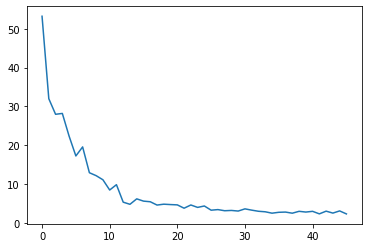

In [0]:
lt = [53.246,31.981,27.964,28.182,22.331,17.218,19.549,12.895,12.134,11.077,8.435,9.810,5.301,4.752,
      6.158,5.572,5.409,4.556,4.781,4.680,4.604,3.744,4.576,3.954,4.315,3.233,3.385,3.092,3.168,3.010,
      3.575,3.244,2.954, 2.821,2.462,2.689,2.747,2.458,2.942,2.751,2.939,2.285,2.984,2.485,3.046,
      2.272]
plt.plot(lt)

In [0]:
save_file = '/content/drive/My Drive/speed/model_2.pth'
torch.save(net.state_dict(), save_file)

## **GRU Network (FAILED)**


---

This section does not need to be run due to bad performance and long training times.

```
# This is formatted as code
```



**GRU Network 1**


---

This is a network based on a simple CNN. input > 
CNN > flatten > GRU > FC layers > output


In [0]:
class GRU_net(nn.Module):
    def __init__(self,input_size, hidden_size):
        super(GRU_net, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = hidden_size
        
        #embedding
        self.conv1 = nn.Conv2d(input_size, 6, kernel_size=3)
        self.conv2 = nn.Conv2d(6, 10, kernel_size=3)
        self.conv3 = nn.Conv2d(10, 16, kernel_size=3)
        self.fc1 = nn.Linear(16 * 45 * 145, 240)
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, hidden_size)
        
        #gru
        self.gru1 = nn.GRU(hidden_size, hidden_size)
        self.gru2 = nn.GRU(hidden_size, hidden_size)       
        
        #fc
        self.fc4 = nn.Linear(hidden_size,hidden_size)
        self.fc5 = nn.Linear(hidden_size,1)
        
    def forward(self, x, hidden):
        #cnn
        out = F.max_pool2d(F.relu(self.conv1(x)),2)
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = out.view(-1, 16 * 45 * 145)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        #flatten
        output = out.view(1, 1, -1)
        output, hidden = self.gru1(output, hidden)
        output, hidden = self.gru2(output, hidden)
        #fc
        pred = F.relu(self.fc4(output))
        pred = self.fc5(pred)
        return pred, hidden
      
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

IMG_CHANNEL = 3
HIDDEN_SIZE = 40

gru_net = GRU_net(IMG_CHANNEL,HIDDEN_SIZE).to(device)

def test_gru(img):
    test_hidden = gru_net.initHidden()
    inputs = img[None, :, :]
    output, hidden = gru_net(inputs,test_hidden)
    return output
  
print(test_gru(seq_test[0][3].to(device)))
print(gru_net.parameters)

tensor([[[-0.0813]]], device='cuda:0', grad_fn=<AddBackward0>)
<bound method Module.parameters of GRU_net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=104400, out_features=240, bias=True)
  (fc2): Linear(in_features=240, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=40, bias=True)
  (gru1): GRU(40, 40)
  (gru2): GRU(40, 40)
  (fc4): Linear(in_features=40, out_features=40, bias=True)
  (fc5): Linear(in_features=40, out_features=1, bias=True)
)>


**GRU Network 2**


---

This is a network based on resnet. input > 
Resnet-like CNN > flatten > GRU > FC layers > output

In [0]:
class GRU_net(nn.Module):
    def __init__(self,input_size, hidden_size):
        super(GRU_net, self).__init__()   
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = hidden_size
        
        #cnn - resnet
        self.conv1 = nn.Conv2d(input_size, 6, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(6, 10, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=10)
        self.convi1 = nn.Conv2d(3, 10, kernel_size=1)
        
        #downsample
        self.downsample = nn.Conv2d(10, 10, 3, stride=2, padding=1)
        
        self.conv3 = nn.Conv2d(10, 12, kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=12)
        self.relu = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(12, 14, kernel_size=3,padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=14)
        self.convi2 = nn.Conv2d(10, 14, kernel_size=1)        
        
        #flatten
        self.fc1 = nn.Linear(14 * 75 * 113, 512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128, hidden_size)
        
        #gru
        self.gru1 = nn.GRU(hidden_size, hidden_size)
        self.gru2 = nn.GRU(hidden_size, hidden_size)       
        
        #fc
        self.fc4 = nn.Linear(hidden_size,24)
        self.fc5 = nn.Linear(24,1)
        
    def forward(self, x, hidden):
        identity = x
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = self.bn2(out)
        identity = self.convi1(identity)
        out += identity
        out = F.relu(out)

        out = self.downsample(out)

        identity = out
        out = self.conv3(identity)
        out = F.relu(self.bn3(out))
        out = self.conv4(out)
        out = F.relu(self.bn4(out))
        identity = self.convi2(identity)
        out += identity
        out = self.relu(out)  

        out = out.view(-1, 14 * 75 * 113)
    
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))     
        out = self.relu(self.fc3(out)) 
        
        output = out.view(1, 1, -1)
        
        output, hidden = self.gru1(output, hidden)
        output, hidden = self.gru2(output, hidden)
        
        out = self.relu(self.fc4(out)) 
        pred = self.fc5(out)
        return pred, hidden
      
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

IMG_CHANNEL = 3
HIDDEN_SIZE = 40

gru_net = GRU_net(IMG_CHANNEL,HIDDEN_SIZE).to(device)

def test_gru(img):
    test_hidden = gru_net.initHidden()
    inputs = img[None, :, :]
    output, hidden = gru_net(inputs,test_hidden)
    return output
  
print(test_gru(seq_test[0][3].to(device)))
print(gru_net.parameters)

## **Training For Recurrent Networks**

---

This section does not need to be run.

In [0]:
criterion = nn.MSELoss()

gru_optimizer = optim.SGD(gru_net.parameters(), lr=0.01, momentum=0.3,nesterov=True)

def train_iter(input_tensor, target_tensor, gru, gru_optimizer, criterion):
    hidden = gru_net.initHidden()
    gru_optimizer.zero_grad()
    
    input_length = input_tensor.size(0) #sequence of 3
    outputs = torch.zeros(input_length, 1, device=device)
    
    loss = 0.0
    
    for frame_idx in range(input_length):
        input_img = input_tensor[frame_idx].unsqueeze(0).float() #Channel x Batch
        output,hidden = gru_net(input_img,hidden)
        outputs[frame_idx] = output[0, 0]
  
    pred = outputs[len(outputs)-1]
    loss += criterion(pred, target_tensor.unsqueeze(0))
    
    loss.backward()
    
    gru_optimizer.step()
    
    return loss.item()

def train(epochs = 1,batch_size=2, print_every=4590):
    start = time.time()
    plot_losses = []
    print_loss = print_every
    
    for epoch in range(epochs):
      start = time.time()
      running_loss = 0.0
      
      for phase in ['train','val']:
        if phase == 'train':
          gru_net.train()
          
          print('Training...')
          
          running_loss = 0.0
          loss = 0.0

          for idx, data in enumerate(dataloaders['train']):
            seq = data['seq'].to(device)
            label = data['label'].to(device)
            
            for seq_idx in range(batch_size):
              r_loss = train_iter(seq[seq_idx], label[seq_idx], gru_net, gru_optimizer, criterion)
              running_loss += r_loss
                
            if idx % print_loss == (print_loss-1) and idx != 0:
                loss = (running_loss)/(idx*batch_size)
                plot_losses.append(loss)
                print('Loss: {} Time: {} Done: {}%'.format( loss, timeSince(start, (idx*4)/dataset_sizes['train']), int(round((idx*4)/dataset_sizes['train'],2)*100 )))

          print('Epoch: {} Loss: {}'.format(str(epoch+1),loss))
        if phase == 'val':
          print('Computing accuracy...')
          print('\n')
        
    stop = time.time()
    finished = asMinutes(stop-start)
    return finished, plot_losses

fin_time, to_plot = train(epochs=2, batch_size=2, print_every=10) #1147
print(fin_time)

## **Evaluation CNN**

---

Evaluation for CNN

In [0]:
save_file = '/content/drive/My Drive/speed/model_2.pth'

model = models.resnet18(pretrained=False)
num_ftrs_linear = model.fc.in_features
model.fc = nn.Linear(num_ftrs_linear, 1)

model.load_state_dict(torch.load(save_file))
model.eval()

model.to(device)
print(device)

cuda


In [0]:
from collections import deque 

val_idx = list(range(num_frames))[18400:]

preds = []
preds_smooth = []
preds_smooth_long = []

acc_3 = 0.0
acc_5 = 0.0
acc_10 = 0.0

running_loss = 0.0
running_loss_smooth = 0.0
running_loss_smoother = 0.0

pred_buffer = deque([])
pred_buffer_long = deque([])

criterion = nn.MSELoss()

start = time.time()
with torch.no_grad():
  for idx in val_idx:
    if(len(pred_buffer) > 0):
      pred_buffer.popleft()
      pred_buffer_long.popleft()
    
    inputs = speed_datasets['val'].__getitem__(idx)
    imgs = inputs['seq'].to(device)
    label = inputs['label']
    labels = torch.reshape(label,[-1,1]).to(device)
    
    outputs = model(imgs.unsqueeze(0))
    
    while(len(pred_buffer)<5):
      pred_buffer.append(outputs.item())
      
    while(len(pred_buffer_long)<25):
      pred_buffer_long.append(outputs.item())

    smooth_pred = torch.tensor([max(0.0000,sum(pred_buffer)/5.0)]).to(device).unsqueeze(0)
    smooth_pred_long = torch.tensor([max(0.0000,sum(pred_buffer_long)/25.0)]).to(device).unsqueeze(0)

    loss_unsmooth = criterion(outputs, labels)
    loss_smooth = criterion(smooth_pred, labels)
    loss_smoother = criterion(smooth_pred_long, labels) 
    
    running_loss += loss_unsmooth.item()
    running_loss_smooth += loss_smooth.item()
    running_loss_smoother += loss_smoother.item()

    for x in range(len(outputs)):
      preds.append(outputs[x])
      preds_smooth.append(smooth_pred)
      preds_smooth_long.append(smooth_pred_long)
      
    if(idx)%100 == 99:
      print(timeSince(start, (idx-18400)/2000))

lv = (float(running_loss) / float(dataset_sizes['val']))
lvs = (float(running_loss_smooth) / float(dataset_sizes['val']))
lvsl = (float(running_loss_smoother) / float(dataset_sizes['val']))

0m 5s (- 1m 39s)
0m 10s (- 1m 33s)
0m 15s (- 1m 28s)
0m 20s (- 1m 22s)
0m 25s (- 1m 17s)
0m 31s (- 1m 12s)
0m 36s (- 1m 7s)
0m 41s (- 1m 2s)
0m 46s (- 0m 57s)
0m 51s (- 0m 52s)
0m 57s (- 0m 46s)
1m 2s (- 0m 41s)
1m 7s (- 0m 36s)
1m 12s (- 0m 31s)
1m 17s (- 0m 26s)
1m 22s (- 0m 20s)
1m 28s (- 0m 15s)
1m 33s (- 0m 10s)
1m 38s (- 0m 5s)
1m 43s (- 0m 0s)


4.008810137020673
3.403219356877614
3.3267528142849727


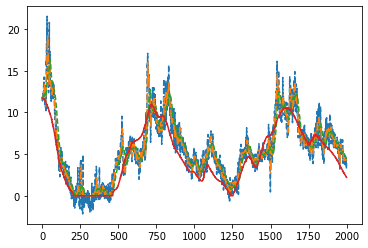

In [0]:
plt.plot(preds[:],linestyle='--')
plt.plot(preds_smooth[:],linestyle='-.')
plt.plot(preds_smooth_long[:],linestyle='--')
plt.plot(speed_arr[18400:])
print(lv)
print(lvs)
print(lvsl)

## **Evaluation GRU**


---

Evaluation for GRU. This section does not need to be run.

In [0]:
def test_one(gru):
  inputs = next(iter(dataloaders['val']))
  input_tensor = inputs['seq'][0].to(device)
  label = inputs['label'][0].to(device)
  
  gru.eval()
  
  print(input_tensor.shape)
  
  hidden = gru_net.initHidden()
  
  outputs = torch.zeros(4, 1, device=device)

  for frame_idx in range(4):
        input_img = input_tensor[frame_idx].unsqueeze(0) #Channel x Batch
        output, hidden = gru_net(input_img,hidden)
        outputs[frame_idx] = output[0, 0]
  
  print(outputs)
  pred = outputs[len(outputs)-1]
  
  print('Label: {} Prediction: {}'.format(label.item(),pred.item()))
  print(abs(label.item()-pred.item())**2)
  return
        
test_one(gru_net)

In [0]:
preds = []
def validate_acc(gru):
  acc_1 = 0
  acc_2 = 0
  acc_4 = 0
  gru.eval()
  for idx, data in enumerate(dataloaders['val']):
    for batch_idx in range(2):
      hidden = gru_net.initHidden()
      outputs = torch.zeros(4,1,device=device)
      
      input_tensor = data['seq'][batch_idx].to(device)
      label = data['label'][batch_idx].to(device)
      
      for frame_idx in range(4):
        input_img = input_tensor[frame_idx].unsqueeze(0)
        output, hidden = gru_net(input_img,hidden)
        outputs[frame_idx] = output[0,0]
        
      pred = outputs[len(outputs)-1]
      preds.append(pred)
      #print(pred,label)
      if (abs(label.item()-pred.item())) <= 1.73:
        acc_1 += 1
      if (abs(label.item()-pred.item())) <= 2.24:
        acc_2 += 1
      if (abs(label.item()-pred.item())) <= 3.16:
        acc_4 += 1
        
      print(pred)
        
  return (float(acc_1) / float(dataset_sizes['val'])), ( float(acc_2)/ float(dataset_sizes['val']) ), (float(acc_4) / float(dataset_sizes['val']))

MSE_3, MSE_5, MSE_10 = validate_acc(gru_net)

print('Scores')
print(MSE_3*100, MSE_5*100, MSE_10*100)

## **Test**


---

This section does not need to be run. I have not written it yet.

In [0]:
test_dir = os.path.join(os.getcwd(),'test_dir')
preds = []

!mkdir test_dir

In [0]:
def split_test(video_dir = train_video, print_every=1000):
    start = time.time()
    num_frames = 20400
    
    cap = cv2.VideoCapture(test_video)
    current_frame = 0
    print('Creating Images...')
    while(True):
        ret, frame = cap.read()
        if ret:
            img = os.path.join(frame_dir,str(current_frame)+'.jpg')
            cv2.imwrite(img,frame)
            current_frame += 1
            if current_frame % print_every == 0:
                print(timeSince(start,current_frame/num_frames))
        else:
            print('Wrote {} Frames...'.format(current_frame))
            break
    cap.release()
    cv2.destroyAllWindows()
    
split_test()
    
def show_frame():
    frame = np.random.choice(10798,1)[0]
    img_frame = os.path.join(test_dir,'{}.jpg'.format(frame))
    print('Frame: {} Speed: {} Image: {}'.format(frame, speed_arr[frame], img_frame))
    img = Image.open(img_frame)
    plt.imshow(img)

#show_frame()

In [0]:
def predict(print_every=100):
  prds = []
  return preds

def write(preds):
    with open(pred_txt,'w') as f:
        for pred in preds:
            f.write('{}\n'.format(pred))

write(preds2)